Image processing is a critical aspect of computer vision that involves a variety of operations to prepare images for analysis or further processing. Image processing can be broadly categorized into two major subfields:
* Local filtering
* Image segmentation

## 1. Local Filtering
Local filtering involves applying a filter to small regions of an image to selectively enhance or suppress certain features. This technique is commonly used for tasks such as edge detection, noise reduction, and contrast enhancement.

For what follows, we'll first work with a 1D-step signal.

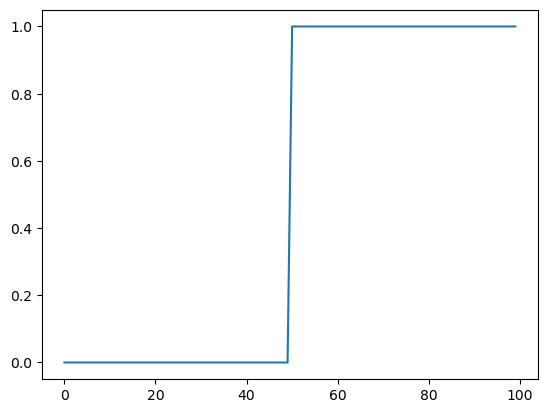

In [1]:
import matplotlib.pyplot as plt
import numpy as np

step_signal = np.zeros(100)
step_signal[50:] = 1
fig, ax = plt.subplots()
ax.plot(step_signal);

Next we add some noise to this signal.

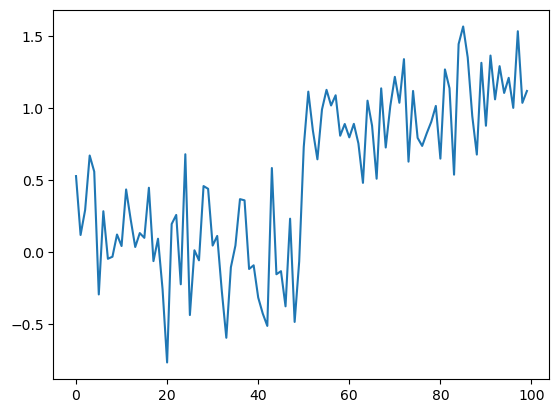

In [2]:
# Just to make sure we all see the same results
np.random.seed(0)

noisy_signal = (step_signal
                + np.random.normal(0, 0.3, step_signal.shape))
fig, ax = plt.subplots()
ax.plot(noisy_signal);

The simplest way to recover something that looks a bit more like the original signal is to definie a moving average filter. Its a sliding window, which is moved along the signal one step at a time. The output at each point is computed as the average of the signal values within the window centered at that point.

The process steps:
* Center a kernel on a pixel
* Multiply the pixels under that kernel by the values in the kernel
* Sum all the those results
* Replace the center pixel with the summed result

Also known as convolution.

⚠️ It's advised in practice to use `np.convolve` when the kernel has a **symmetrical** shape, while `np.correlate` is preferred when the kernel has an **asymmetric** shape.

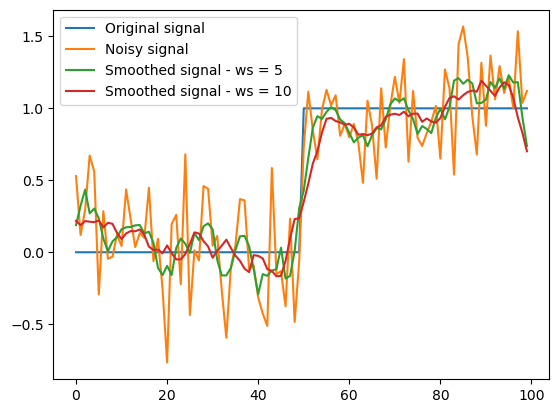

In [3]:
# Apply a moving average filter to smooth out the noisy signal
window_size = 5
moving_average = np.ones(window_size) / window_size
smoothed_signal = np.correlate(noisy_signal, moving_average, mode='same')

window_size2 = 10
moving_average2 = np.ones(window_size2) / window_size2
smoothed_signal2 = np.correlate(noisy_signal, moving_average2, mode='same')

# Plot the original signal, noisy signal, and filtered signal
plt.plot(step_signal, label='Original signal')
plt.plot(noisy_signal, label='Noisy signal')
plt.plot(smoothed_signal, label='Smoothed signal - ws = 5')
plt.plot(smoothed_signal2, label='Smoothed signal - ws = 10')
plt.legend()
plt.show()

In [4]:
def convolve_demo(signal, kernel):
    ksize = len(kernel)
    convolved = np.correlate(signal, kernel)
    def filter_step(i):
        fig, ax = plt.subplots()
        ax.plot(signal, label='signal')
        ax.plot(convolved[:i+1], label='convolved')
        ax.legend()
        ax.scatter(np.arange(i, i+ksize),
                   signal[i : i+ksize])
        ax.scatter(i, convolved[i])
        plt.show()
    return filter_step

from ipywidgets import interact, widgets

i_slider = widgets.IntSlider(min=0, max=len(noisy_signal) - 3,
                             value=0)

interact(convolve_demo(noisy_signal, moving_average),
         i=i_slider);

interactive(children=(IntSlider(value=0, description='i', max=97), Output()), _dom_classes=('widget-interact',…

From the above result, we can determine that increasing the kernal size resulted a more smoothed signal. Because a more wider will consider more neighboring pixels when calculating the new outcome at each pixel. 

However, increasing the kernal size also has some drawbacks:
* First, the filter will become slower and more computationally expensive, as it needs to consider more points at each step.
* Second, if the kernel size is too large relative to the scale of the features in the signal, the filter may start to smooth out important features or introduce artifacts in the output.

Now let’s apply all this knowledge to a real image now instead of a 1D signal.

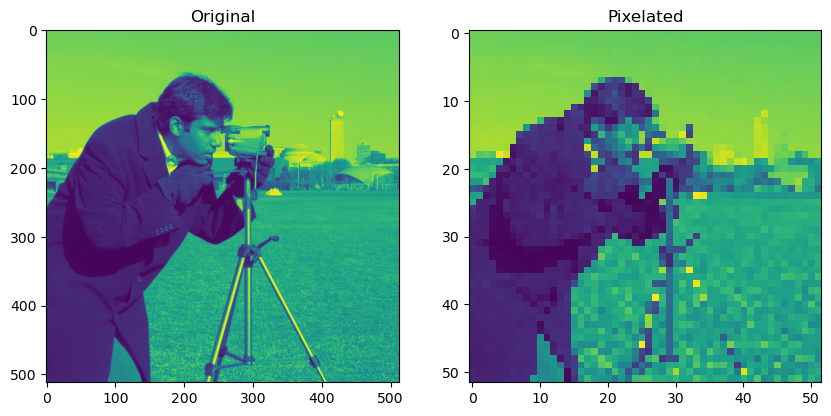

In [5]:
from skimage import data

image = data.camera()

# Create a pixelated version of the original image
pixelated = image[::10, ::10]
# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
# ax0.imshow(image)
# ax1.imshow(pixelated);

from skimage import img_as_float
import numpy as np

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax)
        ax.set_title(label)
        
imshow_all(image, pixelated, titles=['Original', 'Pixelated'])

The line of code `pixelated = image[::10, ::10]` (selecting every 10th pixels) is a downsampled version of the original image, with a resolution that is 1/10th of the original image in both the x and y axes. You can see the highly pixelated result on the right.

### 1.1 Mean Filter

The mean filter is a type of linear filter that replaces the value of each pixel in an image with the mean value of its neighboring pixels. To accomplish this, a mean filer kernel typically has all of its elements set to constant value and divided by the total number of elements in the kernel.\
In other words, it's a kernel with all of its elements set to the same value and the sum of all of them is equal to 1, then it's a mean filter kernel.

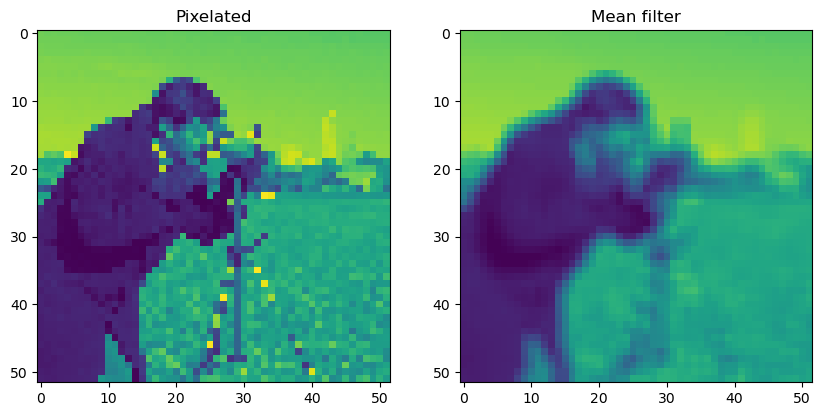

In [6]:
from scipy import ndimage as ndi

mean_kernel = np.full((3, 3), 1/9)

smooth_mean = ndi.convolve(pixelated, mean_kernel)
imshow_all(pixelated, smooth_mean, titles=['Pixelated', 'Mean filter'])

If we compare the picture that has been filtered to the one that looks pixelated, we can notice that the filtered one looks smoother. The reason behind this is that the filtered image removes sharp edges that appear between dark and bright pixels by reducing the intensity of the neighboring pixels. This helps to create a more uniform look throughout the image.

**Dark pixels reduce the intensity of neighboring pixels**, they make the adjacent pixels that are brighter than them appear less bright. Similarly, **the bright pixels do the opposite, they make the adjacent pixels that are darker than them appear less dark**. This process of reducing the intensity of neighboring pixels helps to smooth out the sharp edges that appear between the dark and bright pixels in an image.

The mean filter is a simple smoothing filter that can be used to reduce noise in an image or to **blur the image slightly**. It can also be used to **estimate the background color** of an image, since it averages the pixel values in the neighborhood of each pixel.

However, the mean filter is not typically used for **edge detection**. In fact, it can actually blur edges and make them less distinct. To detect edges, you would typically use a filter designed specifically for edge detection, such as the Sobel, Canny, or Laplacian filters.

### 1.3 Median Filter

The median filter is the classic edge-preserving filter. As the name implies, this filter takes a set of pixels (i.e. the pixels within a kernel or “structuring element”) and returns the median value within that neighborhood. Because regions near a sharp edge will have many dark values and many light values (but few values in between) the median at an edge will most likely be either light or dark, rather than some value in between. In that way, we don’t end up with edges that are smoothed.

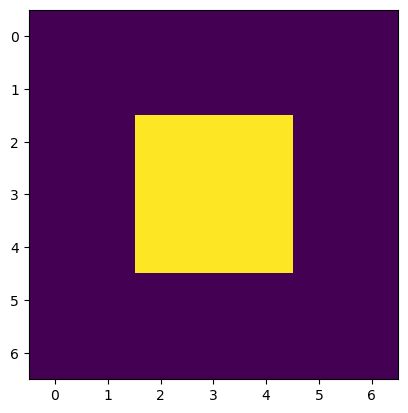

In [7]:
import numpy as np

bright_square = np.zeros((7, 7), dtype=float)
bright_square[2:5, 2:5] = 1

fig, ax = plt.subplots()
ax.imshow(bright_square);

In [8]:
mean_kernel = np.full((3, 3), 1/9)

import scipy.ndimage as ndi

%precision 2
print(bright_square)
print(ndi.correlate(bright_square, mean_kernel))

#--------------------------------------------------------------------------
#  Convolution Demo
#--------------------------------------------------------------------------
from skimage import color
from scipy import ndimage as ndi
from matplotlib import patches

def mean_filter_demo(image, vmax=1):
    mean_factor = 1.0 / 9.0  # This assumes a 3x3 kernel.
    iter_kernel_and_subimage = iter_kernel(image)

    image_cache = []

    def mean_filter_step(i_step):
        while i_step >= len(image_cache):
            filtered = image if i_step == 0 else image_cache[-1][-1][-1]
            filtered = filtered.copy()

            (i, j), mask, subimage = next(iter_kernel_and_subimage)
            filter_overlay = color.label2rgb(mask, image, bg_label=0,
                                             colors=('cyan', 'red'))
            filtered[i, j] = np.sum(mean_factor * subimage)
            image_cache.append(((i, j), (filter_overlay, filtered)))

        (i, j), images = image_cache[i_step]
        fig, axes = plt.subplots(1, len(images), figsize=(10, 5))

        for ax, imc in zip(axes, images):
            ax.imshow(imc, vmax=vmax)
            rect = patches.Rectangle([j - 0.5, i - 0.5], 1, 1, color='yellow', fill=False)
            ax.add_patch(rect)

        plt.show()
    return mean_filter_step


def mean_filter_interactive_demo(image):
    from ipywidgets import IntSlider, interact
    mean_filter_step = mean_filter_demo(image)
    step_slider = IntSlider(min=0, max=image.size-1, value=0)
    interact(mean_filter_step, i_step=step_slider)


def iter_kernel(image, size=1):
    """ Yield position, kernel mask, and image for each pixel in the image.

    The kernel mask has a 2 at the center pixel and 1 around it. The actual
    width of the kernel is 2*size + 1.
    """
    width = 2*size + 1
    for (i, j), pixel in iter_pixels(image):
        mask = np.zeros(image.shape, dtype='int16')
        mask[i, j] = 1
        mask = ndi.grey_dilation(mask, size=width)
        #mask[i, j] = 2
        subimage = image[bounded_slice((i, j), image.shape[:2], size=size)]
        yield (i, j), mask, subimage


def iter_pixels(image):
    """ Yield pixel position (row, column) and pixel intensity. """
    height, width = image.shape[:2]
    for i in range(height):
        for j in range(width):
            yield (i, j), image[i, j]


def bounded_slice(center, xy_max, size=1, i_min=0):
    slices = []
    for i, i_max in zip(center, xy_max):
        slices.append(slice(max(i - size, i_min), min(i + size + 1, i_max)))
    return tuple(slices)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.33 0.67 1.   0.67 0.33 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]


In [9]:
mean_filter_interactive_demo(bright_square);

interactive(children=(IntSlider(value=0, description='i_step', max=48), Output()), _dom_classes=('widget-inter…

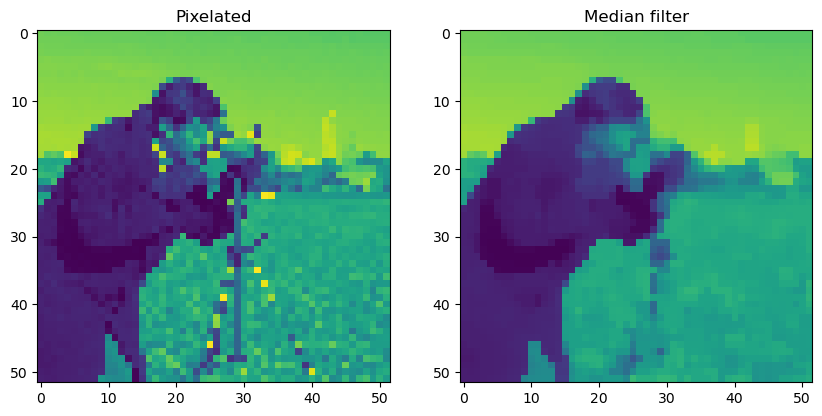

In [10]:
from skimage import filters

median_kernel = np.ones((3, 3))
smooth_median = filters.rank.median(pixelated, footprint=median_kernel)
imshow_all(pixelated, smooth_median, titles=['Pixelated', 'Median filter'])

### 1.3 Gaussian Filter
It is an essential smoothing kernel, and has better smoothing properties than the mean kernel.\
The Gaussian filter, however, doesn’t weight all values in the neighborhood equally. Instead, pixels closer to the center are weighted more than those farther away.

The Gaussian function used in the filter has a bell-shaped curve that assigns higher weights to pixels that are closer to the center and lower weights to pixels that are farther away. The weights are assigned such that the sum of all weights in the neighborhood adds up to 1.0, ensuring that the filtered image has the same overall brightness as the original image.

By assigning higher weights to the pixels closer to the center, the Gaussian filter effectively creates a smoothing effect that reduces high-frequency noise and sharp edges in the image, while preserving low-frequency details such as large edges and structures. This makes the filtered image appear smoother and more visually pleasing.

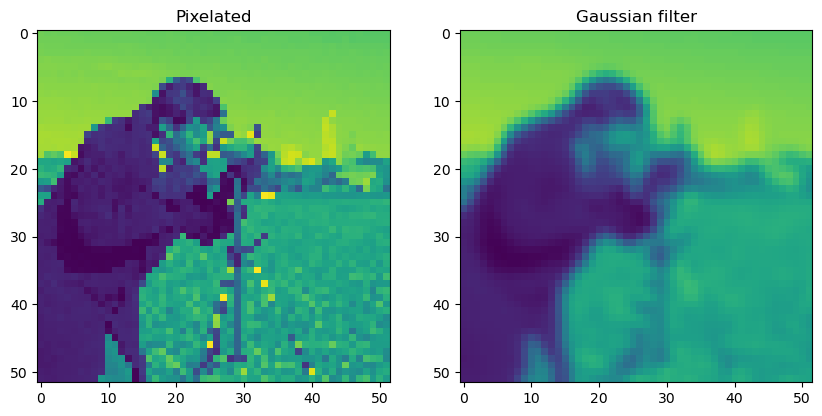

In [11]:
from skimage import filters
from skimage import img_as_float
# The Gaussian filter returns a float image, regardless of input.
# Cast to float so the images have comparable intensity ranges.
pixelated_float = img_as_float(pixelated)
# sigma, the standard deviation, defines the size of the neighborhood.
smooth_gaussian = filters.gaussian(pixelated_float, sigma=1)
imshow_all(pixelated, smooth_gaussian, titles=['Pixelated', 'Gaussian filter'])

The Gaussian filter is often preferred over other smoothing filters, such as the mean filter or the median filter, because it has a distance-dependent weighting that results in a smoother, more gradual transition between neighboring pixels. This helps to preserve more of the fine details in an image, while still reducing noise and smoothing out small variations in intensity.
For a more detailed image and a larger filter, you can see artifacts in the mean filter since it doesn’t take distance into account:

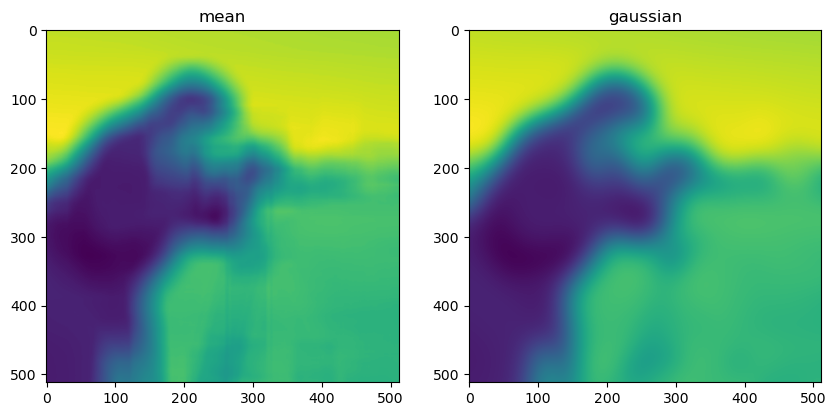

In [12]:
size = 20
structuring_element = np.ones((3*size, 3*size))
smooth_mean = filters.rank.mean(image, structuring_element)
smooth_gaussian = filters.gaussian(image, size)
titles = ['mean', 'gaussian']
imshow_all(smooth_mean, smooth_gaussian, titles=titles)

### 1.4 Edge Filtering
For images, edges are boundaries between light and dark values. The detection of edges can be useful on its own, or it can be used as preliminary step in other algorithms.

In image processing and computer vision, the **gradient** of an image typically refers to the change in pixel intensity values in a particular direction. The gradient can be calculated using different methods, including filters, and is often computed by calculating the difference between adjacent pixel intensities in the x and y directions.

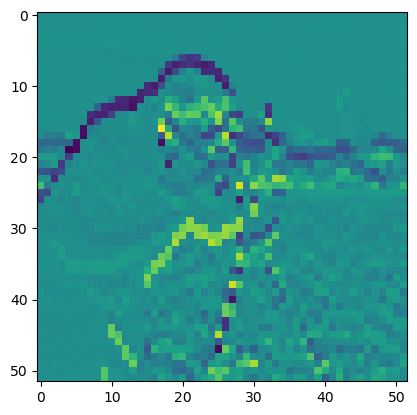

In [13]:
vertical_kernel = np.array([
    [-1],
    [ 0],
    [ 1],
])

gradient_vertical = ndi.correlate(pixelated.astype(float),
                                  vertical_kernel)
fig, ax = plt.subplots()
ax.imshow(gradient_vertical);

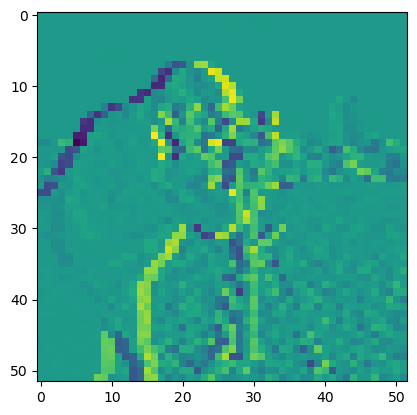

In [14]:
horizontal_kernel = np.array([[-1, 0, 1]])

gradient_horizontal = ndi.correlate(pixelated.astype(float),
                                  horizontal_kernel)
fig, ax = plt.subplots()
ax.imshow(gradient_horizontal);

Here we’ve used filters. Specifically, the vertical and horizontal filters used in the code compute the difference between adjacent pixel intensities in the vertical and horizontal directions, respectively. These filters are convolved with the image, which effectively computes the gradient in each direction for every pixel in the image.

The **gradient magnitude** is simply the absolute value of the gradient. It represents the overall strength or magnitude of the change in pixel intensities at each pixel in the image.


$$\text{gradient\_magnitude} = \sqrt{\text{gradient\_vertical}^2 + \text{gradient\_horizontal}^2}$$


In this formula, $\text{gradient_vertical}$ and $\text{gradient_horizontal}$ represent the vertical and horizontal gradients of the image, respectively, calculated using the filters specified in the code you provided. The gradient magnitude is calculated by taking the square root of the sum of the squares of the two gradients, as shown in the formula above.


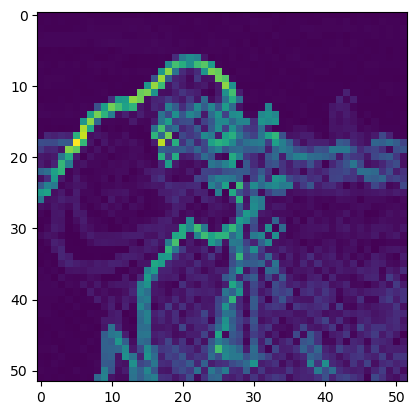

In [15]:
gradient_magnitude = np.sqrt(np.power(gradient_vertical, 2)
                             + np.power(gradient_horizontal, 2))
fig, ax = plt.subplots()
ax.imshow(gradient_magnitude);

The **Sobel filter** is a popular filter used for edge detection in image processing, and it works by computing the gradient of an image using two kernels, one for the x direction (horizontal) and one for the y direction (vertical). The x and y direction kernels are then convolved with the image to calculate the horizontal and vertical gradients, which are used to calculate the gradient magnitude and direction at each pixel in the image.

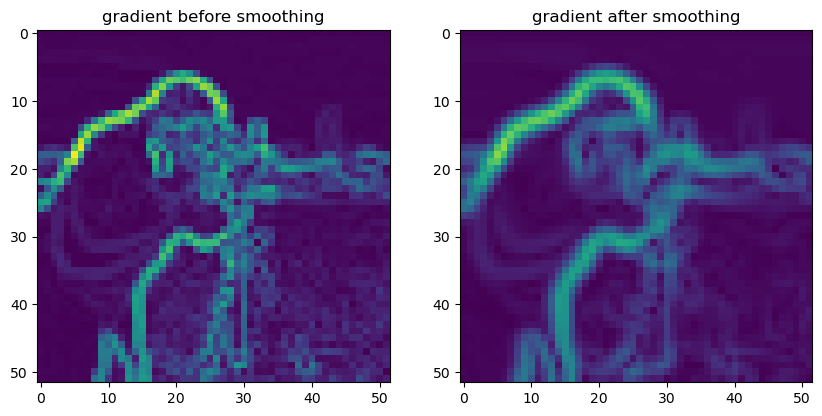

In [16]:
smooth = filters.gaussian(pixelated_float, sigma=1)
pixelated_gradient = filters.sobel(pixelated)
gradient = filters.sobel(smooth)
titles = ['gradient before smoothing', 'gradient after smoothing']
# Scale smoothed gradient up so they're of comparable brightness.
imshow_all(pixelated_gradient, gradient*1.5, titles=titles)

Smoothing is often used as a preprocessing step in preparation for feature detection and image-enhancement operations because sharp features can distort results. Notice how the edges look more continuous in the smoothed image.

The smoothing operation can reduce the overall intensity of the image, and by scaling the smoothed gradient, we can bring its brightness closer to the brightness of the original gradient. Multiplying the smoothed gradient by a factor of 1.8 (in this case) makes it brighter, so that it is more comparable to the original gradient. This allows us to better see the differences between the original and smoothed gradient images.

⚠️ This sequence is not **commutative** because the order in which the operations are performed matters. Smoothing the image first will change the image data and make the edges less sharp, so running the Sobel edge detection algorithm on the smoothed image will produce different results than if the Sobel edge detection algorithm was run first and then the image was smoothed. However, this sequence is an example of **assortativity** because both operations are intended to enhance edges in the image, with the smoothing operation helping to reduce noise and enhance edges, and the Sobel edge detection algorithm identifying the locations of edges.

#### Exercice
Let’s pretend we have an image and the “ground truth” image of what we want to detect. Here we'll implement machine learning to find a 3x3 convolutional filter that can recover this target?

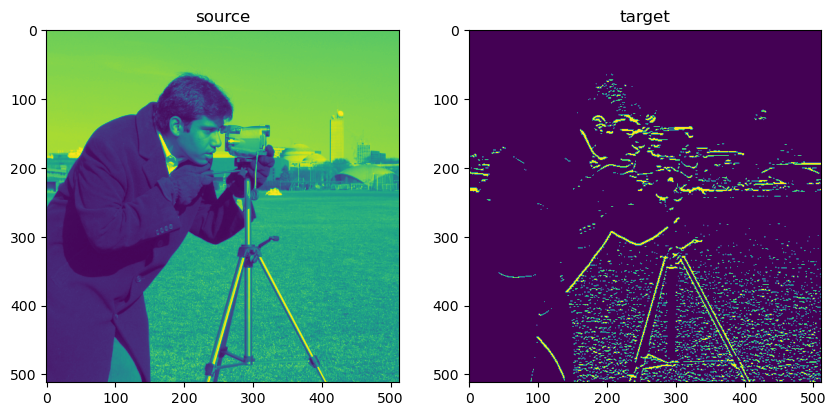

In [17]:
target = (filters.sobel_h(image) > 0.07)
imshow_all(image, target, titles=['source', 'target'])

First, we'll prepare our input data.

In [18]:
from skimage.util import view_as_windows

X = view_as_windows(image, (3, 3)) # A
print(X.shape)
X = X.reshape(-1, 3, 3) # B
print(X.shape)
X = X.reshape(-1, 9) # C
print(X.shape)

(510, 510, 3, 3)
(260100, 3, 3)
(260100, 9)


Line `A` creates a sliding window view of the input image, where each window is of size `(3, 3)`. The `view_as_windows` function returns an array of shape `(height - 2, width - 2, 3, 3)` where `height` and `width` are the height and width of the input image. Each window is stored as a 3D subarray of size `(3, 3)`.

The reason for subtracting **2** from the height and width of the image is that when we apply a sliding window of size (3, 3) to the image, the window "slides" over the image and we lose one row and one column of pixels at the top and left edges of the image, and another row and column of pixels at the bottom and right edges of the image.

Line `B` of code reshapes the 4D array `X` returned by `view_as_windows` into a 3D array of shape `(height - 2) * (width - 2), 3, 3)`. The `-1` argument in the first dimension of the reshape method tells NumPy to infer the size of this dimension based on the other dimensions and the total number of elements in the array. In this case, the size of the first dimension will be `(height - 2) * (width - 2)`, which corresponds to the total number of windows in the original array.

Line `C` of code further reshapes the 3D array `X` into a 2D array of shape `(height - 2) * (width - 2), 9)`. This is done to "flatten" each window into a 1D array of length 9, which is more convenient for some types of computations. In this case, each row of the 2D array `X` corresponds to one window of the original image.

In [19]:
# np.ravel?
np.ravel(
    [[1, 2, 3],
     [4, 5, 6]]
)

array([1, 2, 3, 4, 5, 6])

In [20]:
print(target.shape)
print(target[1:-1, 1:-1].shape)
# To guarantee the the target has to same property (shaep) as the source
y = np.ravel(target[1:-1, 1:-1])
y.shape

(512, 512)
(510, 510)


(260100,)

In [21]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
model.fit(X, y)

model.coef_.reshape((3, 3))

array([[-3.96e-01, -7.97e-01, -3.98e-01],
       [-8.30e-04, -6.71e-04,  2.48e-04],
       [ 3.97e-01,  7.96e-01,  3.96e-01]])

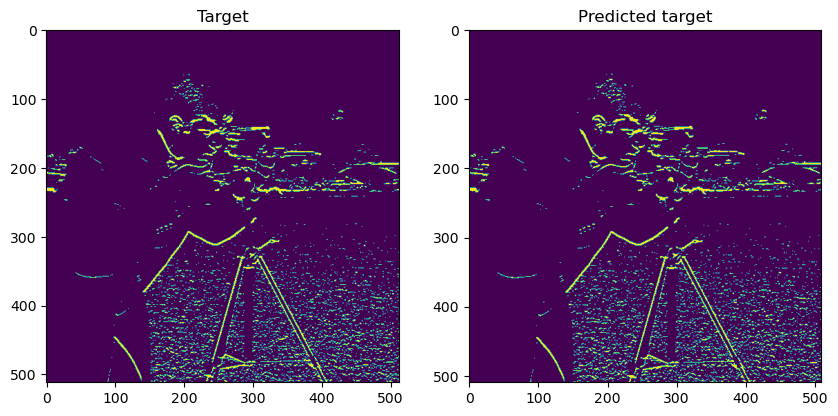

In [22]:
X_test = view_as_windows(image, (3, 3)).reshape(-1, 3, 3).reshape(-1, 9)
y_pred = model.predict(X_test)
target_pred = y_pred.reshape(510, 510)
target_pred = target_pred > 0.5
imshow_all(target, target_pred, titles=['Target', 'Predicted target'])

The model learned to predict whether each 3x3 patch in the image should be classified as an edge or not.

## 2. Image Segmentation
Image segmentation, on the other hand, involves partitioning an image into distinct regions based on some criteria, such as color or texture. This can be useful for object detection, recognition, and tracking. Overall, image processing plays an important role in many applications, such as medical imaging, surveillance, and autonomous driving.\
In this part, we will process our example using image of nuclei.

To start, we'll load and convert the image to grayscale using the `rgb2gray` function from `scikit-image`.

Original image shape: (256, 256, 3)
New image shape: (256, 256)


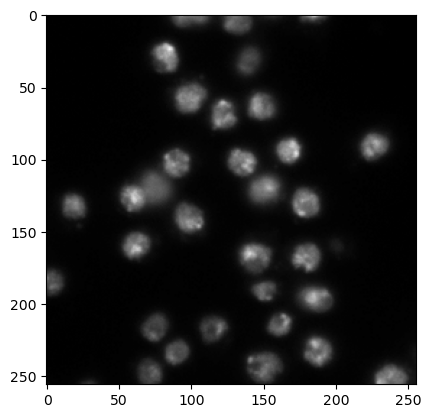

In [23]:
from skimage import io

image = io.imread("C:/Users/Sadek/Documents/GitHub/Project/Image-processing/data/nuclei_2.png")

plt.imshow(image);

# Print the image dimensions
print('Original image shape: {}'.format(image.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray

image_gray = rgb2gray(image)
print('New image shape: {}'.format(image_gray.shape))

### 2.1 Removing background
If we assume that an image contains two classes of data, namely objects of interest and the background, then we can use a simple approach to separate them. We can first examine the intensity distribution of the data and expect to see two peaks corresponding to the two classes. By finding the optimal separation value, we can remove the background and keep only the objects of interest, making it easier to count them.

One commonly used method to find the optimal separation value is the **Otsu** method, which models the image as a bimodal distribution and searches for the threshold that maximizes the between-class variance.

In [24]:
thresh_val = filters.threshold_otsu(image_gray)
mask = np.where(image_gray > thresh_val, 1, 0)

# Make sure the larger portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

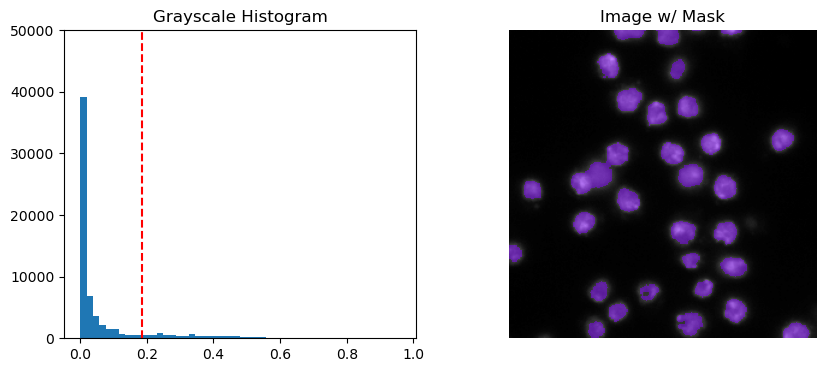

In [25]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = image_gray.flatten()
plt.hist(im_pixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--', color='r')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(image_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

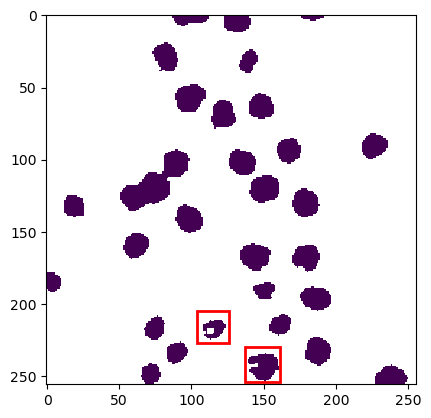

In [26]:
# Create a rectangle patch
nuclei_rect_1 = patches.Rectangle((104, 205), 22, 22, linewidth=2, edgecolor='r', facecolor='none')
nuclei_rect_2 = patches.Rectangle((137, 230), 24, 24, linewidth=2, edgecolor='r', facecolor='none')

# Create a plot and add the rectangle patch to the axis
fig, ax = plt.subplots()
ax.imshow(mask_for_display)
ax.add_patch(nuclei_rect_1)
ax.add_patch(nuclei_rect_2)

# Show the plot
plt.show()

We've used Otsu's method to generate a binary mask that distinguishes the nuclei cells from the background in an image. While the overall mask is effective, we can notice that some of the individual submasks do not accurately represent the boundaries of the individual nuclei cells (boxed in red). This issue is known as **undersegmentation**, where a single object in an image is erroneously split into multiple sub-objects.

Images with noise can pose a challenge for accurately identifying foreground and background regions, due to small variations in pixel values. In such cases, denoising techniques can prove helpful in reducing the noise and smoothing the image. By doing so, we can achieve more precise thresholding and obtain more accurate separation of foreground and background regions.

In [27]:
denoised = ndi.median_filter(image_gray, size=3)

thresh_val = filters.threshold_otsu(denoised)
mask = np.where(denoised > thresh_val, 1, 0)

# Make sure the larger portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

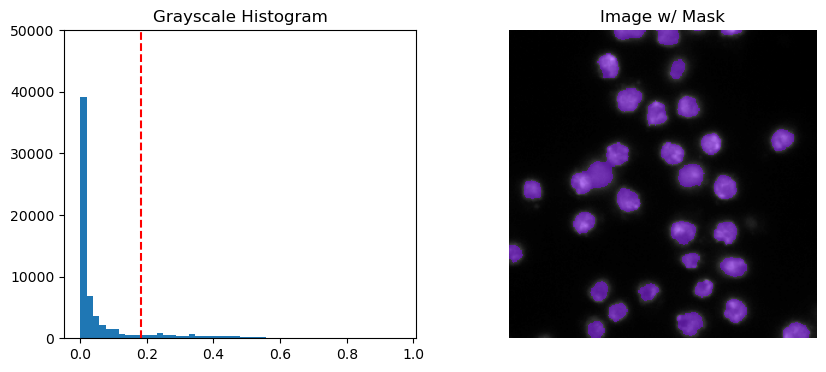

In [28]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = image_gray.flatten()
plt.hist(im_pixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--', color='r')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display_denoised = np.where(mask, mask, np.nan)
plt.imshow(image_gray, cmap='gray')
plt.imshow(mask_for_display_denoised, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

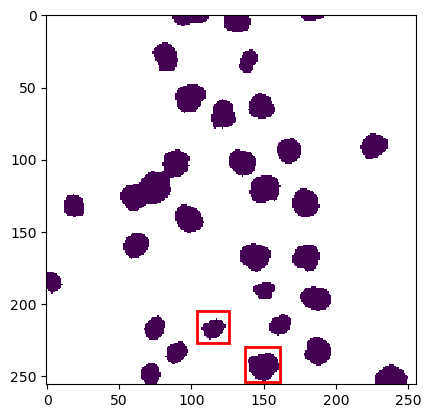

In [29]:
# Create a rectangle patch
nuclei_rect_1 = patches.Rectangle((104, 205), 22, 22, linewidth=2, edgecolor='r', facecolor='none')
nuclei_rect_2 = patches.Rectangle((137, 230), 24, 24, linewidth=2, edgecolor='r', facecolor='none')

# Create a plot and add the rectangle patch to the axis
fig, ax = plt.subplots()
ax.imshow(mask_for_display_denoised)
ax.add_patch(nuclei_rect_1)
ax.add_patch(nuclei_rect_2)

# Show the plot
plt.show()

It appears that the expected outcome has been improved to some extent.

### 2.2 Segmenting an Image into Distinct Objects using Masks

To meet the requirements of this part, we need to derive individual masks for each nucleus. To achieve this, one approach is to identify all objects in the mask that are connected, and assign a unique label to each of them.

In [30]:
from skimage import measure

labels = measure.label(mask)
props = measure.regionprops(labels, image)

print('There are {} separate components / objects detected.'.format(len(props)))

There are 31 separate components / objects detected.


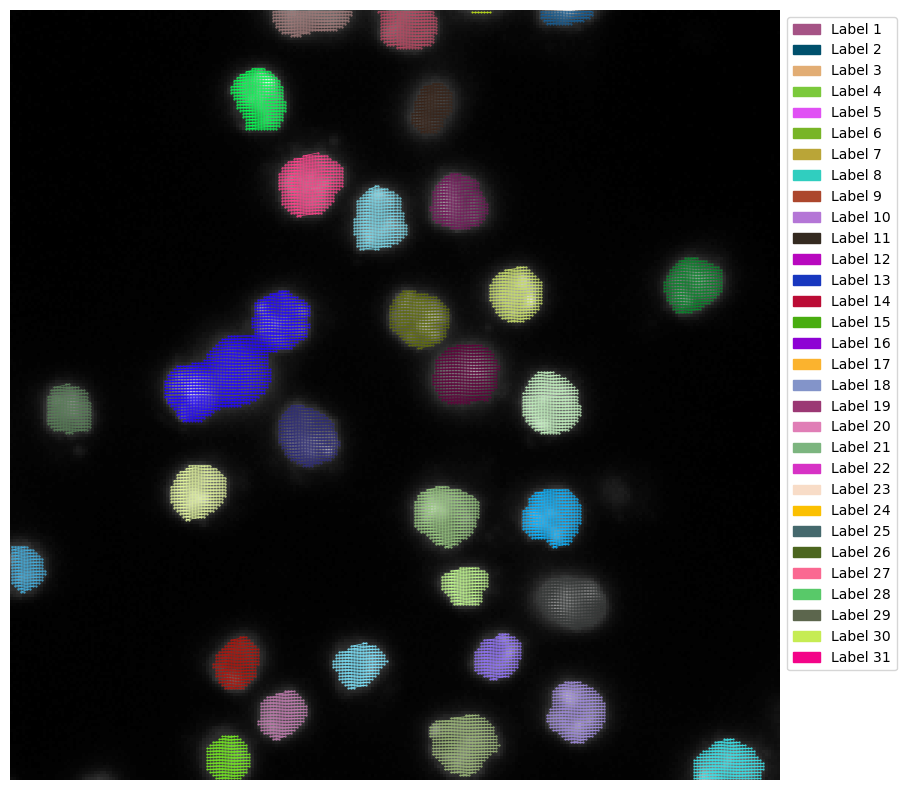

In [31]:
import matplotlib.patches as mpatches

# Plot the original image
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image, cmap='gray')

# Plot the contours of each component on the image
for region in props:
    label = region.label
    coords = region.coords
    x = coords[:, 1]
    y = coords[:, 0]
    color = np.random.rand(3,)
    ax.plot(x, y, '.', color=color, markersize=1)
    ax.plot(x, y, color=color, linewidth=0.5)


# Add legend
handles = [mpatches.Patch(color=np.random.rand(3,), label=f'Label {i+1}') for i in range(len(props))]
plt.legend(handles=handles, bbox_to_anchor=(1, 1), loc='upper left')

plt.axis('off')
plt.show()

A brief inspection of this simple image reveals one issue: some cells are merged into a single mask, as in the case of the middle cell (left side of the image).

Traditional image processing techniques for segmentation involve applying mathematical operations to an image to identify and extract objects or regions of interest. However, these techniques can have limitations, such as being sensitive to noise and requiring extensive manual tuning.

Deep learning approaches, such as the U-Net architecture, offer an alternative solution for image segmentation. They use convolutional neural networks to learn features directly from the data, allowing for more robust and automated segmentation. **U-Net**, in particular, is a popular architecture for biomedical image segmentation, where it has achieved state-of-the-art results.